In [2]:
import pandas as pd
import numpy as np
import cv2
import os
from termcolor import colored
import matplotlib.pyplot as plt

images = pd.DataFrame()

data_path = r"data"
imaging_path = r"imaging"
filenames = os.listdir(os.path.join(data_path, imaging_path))
depths = pd.read_csv(os.path.join(data_path, "depths.csv"))

for i in filenames:
    img = cv2.imread(os.path.join(data_path, imaging_path, i), 0)
    try:
        depth = depths[depths["Filenames"].str.lower() == i.lower()][
            "Depth from lung surface (in micrometers) where image was acquired"
        ].values[0]
        # some files are named with SK658 and some with Sk658
    except IndexError:
        print(f"couldn't find depth for file {i}")
        continue
    images = pd.concat(
        [images, pd.DataFrame([{"filename": i, "image": img, "depth": depth}])],
        ignore_index=True,
    )
display(images.head())

couldn't find depth for file MASK_Sk658 Llobe ch010053.jpg


,filename,image,depth
0,MASK_SK658 Slobe ch010129.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3250
1,MASK_SK658 Slobe ch010115.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8800
2,MASK_SK658 Slobe ch010114.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9900
3,MASK_SK658 Slobe ch010060.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8400
4,MASK_SK658 Slobe ch010048.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",540


In [3]:
white_counts = []
black_counts = []
white_percents = []


for x_glm in range(len(images)):
    _, binary = cv2.threshold(images.iloc[x_glm]["image"], 127, 255, cv2.THRESH_BINARY)

    white = np.sum(binary == 255)
    black = np.sum(binary == 0)

    white_counts.append(white)
    black_counts.append(black)

# print the number of white and black pixels in each image.

print(colored("Counts of pixel by color in each image", "yellow"))
for x_glm in range(len(images)):
    print(colored(f"White pixels in image {x_glm}: {white_counts[x_glm]}", "white"))
    print(colored(f"Black pixels in image {x_glm}: {black_counts[x_glm]}", "black"))
    print()

# calculate the percentage of pixels in each image that are white and make a list that contains these percentages for each filename

for x_glm in range(len(images)):
    white_percent = 100 * (white_counts[x_glm] / (black_counts[x_glm] + white_counts[x_glm]))
    white_percents.append(white_percent)

# print the filename (on one line in red font), and below that line print the percent white pixels and depth

print(colored("Percent white px:", "yellow"))
for x_glm in range(len(images)):
    print(colored(f"{images.iloc[x_glm]['filename']}:", "red"))
    print(f"{white_percents[x_glm]}% White | Depth: {images.iloc[x_glm]['depth']} microns")
    print()

Counts of pixel by color in each image
White pixels in image 0: 82784
Black pixels in image 0: 4111520

White pixels in image 1: 151132
Black pixels in image 1: 4043172

White pixels in image 2: 242340
Black pixels in image 2: 3951964

White pixels in image 3: 142359
Black pixels in image 3: 4051945

White pixels in image 4: 49491
Black pixels in image 4: 4144813

White pixels in image 5: 369855
Black pixels in image 5: 3824449

White pixels in image 6: 56003
Black pixels in image 6: 4138301

White pixels in image 7: 193743
Black pixels in image 7: 4000561

White pixels in image 8: 99131
Black pixels in image 8: 4095173

White pixels in image 9: 120910
Black pixels in image 9: 4073394

White pixels in image 10: 139549
Black pixels in image 10: 4054755

White pixels in image 11: 383479
Black pixels in image 11: 3810825

White pixels in image 12: 119938
Black pixels in image 12: 4074366

White pixels in image 13: 100236
Black pixels in image 13: 4094068

White pixels in image 14: 97032
B

In [4]:
"""Write your data to a .csv file"""

# Create a DataFrame that includes the filenames, depths, and percentage of white pixels
df = pd.DataFrame(
    {"filename": images["filename"], "depth": images["depth"], "white_percent": white_percents}
)

# Write that DataFrame to a .csv file

df.to_csv(os.path.join(data_path, "pct_white_pixels.csv"), index=False)

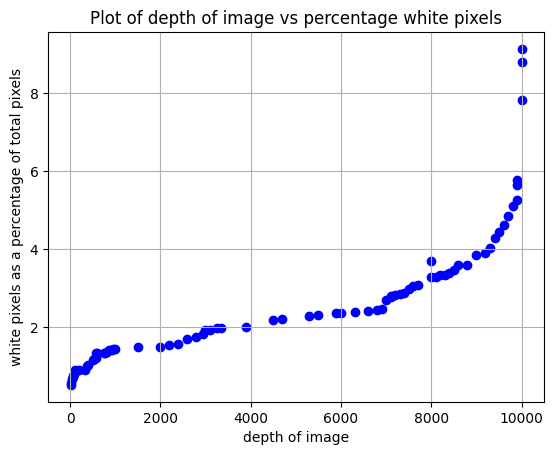

In [5]:
# display graph
plt.scatter(images["depth"], white_percents, marker="o", linestyle="-", color="blue")
plt.title("Plot of depth of image vs percentage white pixels")
plt.xlabel("depth of image")
plt.ylabel("white pixels as a percentage of total pixels")
plt.grid(True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          white_percent   No. Observations:                   78
Model:                            GLM   Df Residuals:                       76
Model Family:                Gaussian   Df Model:                            1
Link Function:                    Log   Scale:                         0.55739
Method:                          IRLS   Log-Likelihood:                -86.882
Date:                Wed, 15 Oct 2025   Deviance:                       42.361
Time:                        21:15:47   Pearson chi2:                     42.4
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9890
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2699      0.120     -2.258      0.0

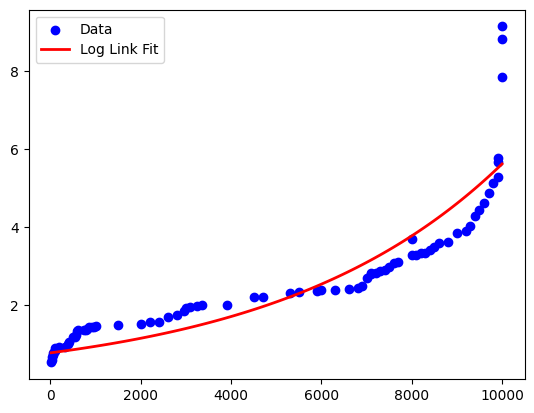

In [37]:
# generalized linear model
import statsmodels.api as sm

# prepare the data
x_glm = df["depth"]
y_glm = df["white_percent"]

# add a constant for the intercept
x_const = sm.add_constant(x_glm)

# fit a generalized linear model (GLM) with Gaussian family
glm_model = sm.GLM(y_glm, x_const, family=sm.families.Gaussian(link=sm.families.links.Log())).fit()

# print the summary
print(glm_model.summary())

# calculate R-squared
fitted_values = glm_model.fittedvalues
ss_total = ((y_glm - y_glm.mean()) ** 2).sum()
ss_residual = ((y_glm - fitted_values) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
print(f"R-squared: {r_squared}")

# plot the regression curve
x_pred = np.linspace(x_glm.min(), x_glm.max(), 100)
x_pred_const = sm.add_constant(x_pred)
y_pred = glm_model.predict(x_pred_const)
plt.scatter(x_glm, y_glm, color="blue", label="Data")
plt.plot(x_pred, y_pred, color="red", linewidth=2, label="Log Link Fit")
plt.legend()
plt.show()

Polynomial Regression R-squared: 0.8937883852417686


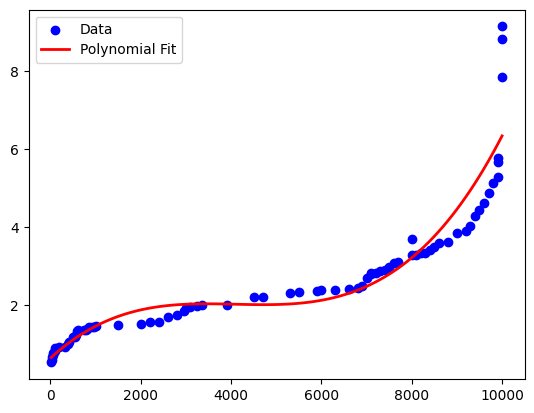

In [36]:
# polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# prepare the data
x_poly = df["depth"].values.reshape(-1, 1)
y_poly = df["white_percent"].values
# transform the features to include polynomial terms
poly = PolynomialFeatures(degree=3)
x_poly_transformed = poly.fit_transform(x_poly)
# fit the polynomial regression model
model = LinearRegression()
model.fit(x_poly_transformed, y_poly)
# make predictions
y_poly_pred = model.predict(x_poly_transformed)
# calculate R-squared
r2 = r2_score(y_poly, y_poly_pred)
print(f"Polynomial Regression R-squared: {r2}")
# plot the polynomial regression curve
x_poly_range = np.linspace(x_poly.min(), x_poly.max(), 100).reshape(-1, 1)
x_poly_range_transformed = poly.transform(x_poly_range)
y_poly_range_pred = model.predict(x_poly_range_transformed)
plt.scatter(x_poly, y_poly, color="blue", label="Data")
plt.plot(x_poly_range, y_poly_range_pred, color="red", linewidth=2, label="Polynomial Fit")
plt.legend()
plt.show()